In [1]:
import pandas as pd
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))

import ModelFramework as mf
import FwtModels.RectWing as rw

## Create Method to Calculate the Eigen Response of a Given model

Model defined by number of b and t shapes and model ID

Using settings for JEC Wing

In [2]:
def Model_Eigen(model_num,b_modes,t_modes):
    p = rw.base_params(b_modes + t_modes + 1)
    sm = mf.SymbolicModel.from_file(f'{b_modes}B{t_modes}T-M{model_num}.py')
    
    dataset_name = 'JEC2'
    # Set JEC Specific parameters
    p.rho.value = 1.225
    p.s_t.value = 12
    p.c.value = 1.8
    p.EI.value = 9.77e6/5
    p.GJ.value = 0.99e6/5*2
    p.rho_t.value = 19.53/5
    p.e_0.value = 0.08
    p.e_1.value = 0
    
    vars_ls =[]
    vars_ls.append((p.Lambda,np.deg2rad([10,17.5,25])))
    vars_ls.append((p.V,np.linspace(0,150,151))) # V must be second
    vars_ls.append((p.alpha_r,np.deg2rad([0,5,10])))
    vars_ls.append((p.ratio_fwt,[0,0.1,0.2,0.3]))
    vars_ls.append((p.m_factor,[0.5,1,1.5]))

    variables = [k for k,v in vars_ls]
    
    calc_fixed = True if np.isin(2,np.array([1,2,3,4])) else False
    flutdf = rw.eigen_perm_params(p,sm,vars_ls,calc_fixed)   
    flutdf.to_pickle(f'Eigen_{b_modes}B{t_modes}T-M{model_num}_{dataset_name}.pkl')

In [3]:
b_modes = 3
t_modes = 3
import multiprocessing as mp

pool = mp.Pool(mp.cpu_count())

for k in range(7):
    pool.apply_async(Model_Eigen,args=(k,b_modes,t_modes))
pool.close()
pool.join()

/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/finta

In [3]:
Model_Eigen(2,3,3)
flutdfv2 = pd.read_pickle(f'Eigen_{3}B{3}T-M{2}_JEC.pkl')

/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)


In [4]:
flutdf = flutdfv2.copy()
flutdf['Damping [%]'] = flutdf['Damping']*-100
flutdf['Coast Angle [Deg]'] = flutdf.apply(lambda row: np.rad2deg(row['q'][-1]),axis=1)
flutdf['Flare Angle [Deg]'] = pd.Categorical(np.rad2deg(flutdf['Lambda']))
flutdf['AoA [Deg]'] = pd.Categorical(np.rad2deg(flutdf['alpha_r']))
flutdf['FWT Mass [%]'] = pd.Categorical(flutdf['delta_m']*100)
flutdf['FWT Ratio [%]'] = pd.Categorical(flutdf['sigma']*100)
flutdf['Mode'] = flutdf.Mode.astype('category')

[(-25, 100)]

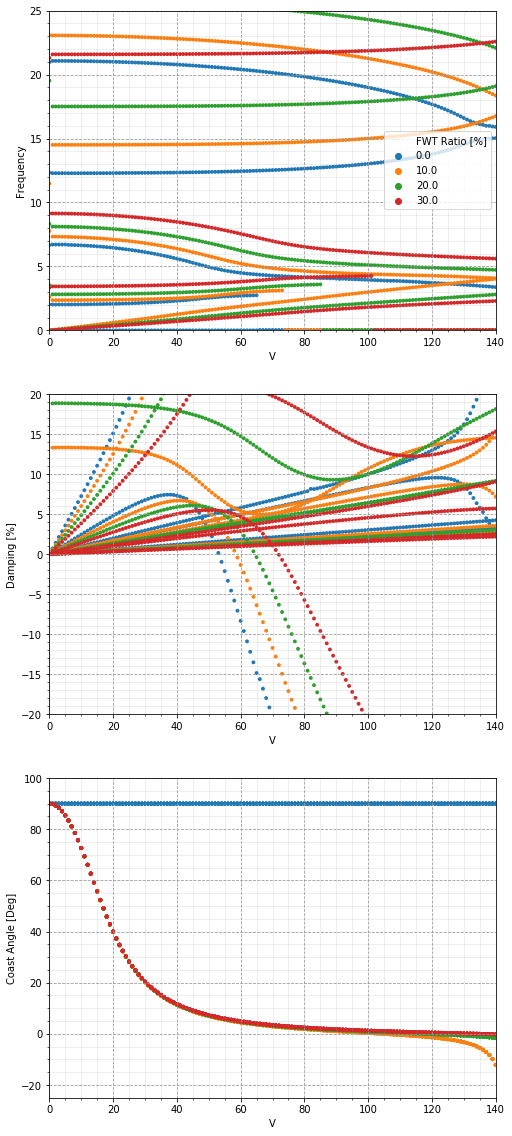

In [7]:
data = flutdf.copy()
data = data[data['Flare Angle [Deg]']==25]
data = data[data['AoA [Deg]']==0]
data = data[data['FWT Mass [%]']==100]
data = data[data['V']<=150]
fig, axes = plt.subplots(3,1,figsize=(8,20))


sns.scatterplot(data=data,x='V',y='Frequency',hue='FWT Ratio [%]',ax=axes[0],edgecolor = 'none',s=15)
sns.scatterplot(data=data,x='V',y='Damping [%]',hue='FWT Ratio [%]',ax=axes[1],legend=False,edgecolor = 'none',s=15)
sns.scatterplot(data=data,x='V',y='Coast Angle [Deg]',hue='FWT Ratio [%]',ax=axes[2],legend=False,edgecolor = 'none',s=15)

for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    axes[i].set(xlim=(0,140))
#axes[0].set(ylim=(0.5,3))
axes[0].set(ylim=(0,25))
axes[1].set(ylim=(-20,20))
axes[2].set(ylim=(-25,100))